In [1]:
from symred.projection import (
    S3_projection, QubitTapering, CS_VQE_LW, 
    StabilizerIdentification, ObservableBiasing, stabilizer_walk
)
from symred.symplectic import *
from symred.utils import exact_gs_energy
from symred.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symred.chem import geometry_from_pubchem, MoleculeBuilder
from matplotlib import pyplot as plt
from functools import reduce
import json

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
with open('data/score_data.json', 'r') as infile:
    scoring_data = json.load(infile)

molecules = [speciesname for speciesname in molecule_geometries.keys() 
             if (speciesname in scoring_data and
                 scoring_data[speciesname]['n_qubits_pre_taper']<100# and
                 #speciesname.find('+')==-1 and
                 #speciesname.find('-')==-1 and
                 #speciesname.find('SINGLET')!=-1
                )
            ]
print(molecules)

['H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CH3OCH3_STO-3G_SINGLET', 'C2H5F_STO-3G_SINGLET', 'CH3COCH3_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HOOH_STO-3G_SINGLET', 'NaCl_STO-3G_SINGLET', 'H2S_STO-3G_SINGLET', 'SiH4_STO-3G_SINGLET']


In [3]:
def build_mol(speciesname, fci=True):
    #print(speciesname in scoring_data)
    mol_data = molecule_geometries[speciesname]
    if 'name' in mol_data:
        print(mol_data['name'])

    atoms  = mol_data['atoms']
    coords = mol_data['coords']
    basis  = mol_data['basis'] #'6-31g' #'cc-pVDZ' #
    spin   = mol_data['multiplicity']
    charge = mol_data['charge']
    geometry = list(zip(atoms, coords))
    molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, run_fci=fci)
    return molecule

# Set molecule parameters
speciesname = 'H2O_STO-3G_SINGLET'
molecule = build_mol(speciesname)

Molecule geometry:
O	0	0	0
H	0.952519	0	0
H	-0.246530058	0.9200627021	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -74.96203967838721
MP2 energy:  -74.99708201366197
CCSD energy: -75.01073164269071
FCI energy:  -75.01084664816946


Number of qubits: 14


In [4]:
def taper_ham(molecule):
    taper_hamiltonian = QubitTapering(molecule.H_q)

    print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
    print('The symmetry generators are\n')
    print(taper_hamiltonian.symmetry_generators)
    print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
    print(taper_hamiltonian.stabilizers.stabilizer_rotations)
    print('\nonto the single-qubit Pauli operators\n')
    print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
    hf_array = molecule.H_fermion.hf_comp_basis_state
    taper_hamiltonian.stabilizers.update_sector(hf_array)
    print(f'\nThe symetry sector corresponding with the reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')
    ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
    #sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
    #sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
    ucc_tap = taper_hamiltonian.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
    n_taper = taper_hamiltonian.n_taper
    tapered_qubits   = taper_hamiltonian.stab_qubit_indices
    untapered_qubits = taper_hamiltonian.free_qubit_indices
    hf_tapered = taper_hamiltonian.tapered_ref_state
    print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))
    return ham_tap, ucc_tap, hf_tapered

ham_tap, ucc_tap, hf_tapered = taper_ham(molecule)

We are able to taper 4 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIZIIZZIIZZIIZ 
 1 IZIZIZIZIZIZIZ 
 1 IIIIZZIIIIIIZZ 
 1 IIIIIIIIZZIIII

and may be rotated via a sequence of Clifford pi/2 rotations

[(1.000+0.000j IIIIIIIIYZIIII, None), (1.000+0.000j IIIIYZIIIIIIZZ, None), (1.000+0.000j YIZIIZZIIZZIIZ, None), (1.000+0.000j IYIZIZIZIZIZIZ, None)]

onto the single-qubit Pauli operators

-1 XIIIIIIIIIIIII 
-1 IXIIIIIIIIIIII 
-1 IIIIXIIIIIIIII 
-1 IIIIIIIIXIIIII

The symetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 0 0 0 0] is [-1 -1  1  1]
The tapered Hartree-Fock state is  1.0000000000 |1111110000>


In [5]:
from symred.projection import CS_VQE, CS_VQE_LW

cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
cs_vqe_2 = CS_VQE(ham_tap, hf_tapered, noncontextual_form='diag')

In [9]:
max_sim_q = 14
def score_CC_generated_stabilizers(max_sim_q=max_sim_q):
    scores = []

    for i in range(1, ham_tap.n_qubits):
        CC_stabilizers = StabilizerIdentification(ucc_tap)
        S_CC           = CC_stabilizers.symmetry_basis_by_subspace_dimension(i)
        stab_score_CC  = cs_vqe.basis_score(S_CC)
        if i <= max_sim_q:
            ham_cs = cs_vqe.project_onto_subspace(S_CC)
            matrix = ham_cs.to_sparse_matrix
            cs_energy = exact_gs_energy(matrix)[0]
            error = cs_energy-molecule.fci_energy
            print(f'{i}-qubit CS-VQE error w.r.t. CCSD is {error:.5f} with stabilizer score {stab_score_CC:.5f}')
        else:
            cs_energy = None
            print(f'{i}-qubit CS-VQE energy not computed - stabilizer score {stab_score_CC:.5f}')

        scores.append((stab_score_CC, cs_energy))
        
    return scores

scores = score_CC_generated_stabilizers()

1-qubit CS-VQE error w.r.t. CCSD is 0.03641 with stabilizer score 0.10762
2-qubit CS-VQE error w.r.t. CCSD is 0.03242 with stabilizer score 0.18922
3-qubit CS-VQE error w.r.t. CCSD is 0.02581 with stabilizer score 0.33421
4-qubit CS-VQE error w.r.t. CCSD is 0.01753 with stabilizer score 0.54761
5-qubit CS-VQE error w.r.t. CCSD is 0.01122 with stabilizer score 0.68639
6-qubit CS-VQE error w.r.t. CCSD is 0.00145 with stabilizer score 0.89338
7-qubit CS-VQE error w.r.t. CCSD is 0.00041 with stabilizer score 0.94456
8-qubit CS-VQE error w.r.t. CCSD is 0.00008 with stabilizer score 0.99105
9-qubit CS-VQE error w.r.t. CCSD is 0.00005 with stabilizer score 0.99477


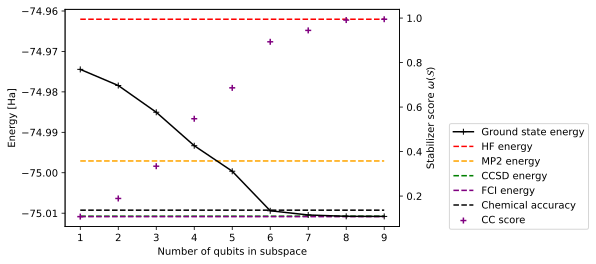

In [10]:
fig,energy_axis = plt.subplots()
X = np.arange(1, ham_tap.n_qubits)
Y_score,Y_energy = zip(*scores)

energy_axis.plot(X[:max_sim_q], Y_energy[:max_sim_q], color='black', marker='+', label='Ground state energy')
energy_axis.hlines(molecule.hf_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(molecule.mp2_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(molecule.ccsd_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
if molecule.fci_energy is not None:
    energy_axis.hlines(molecule.fci_energy, 1, X[-1], ls='--', color='purple', label='FCI energy')
    energy_axis.hlines(molecule.fci_energy+0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_yscale('log')
energy_axis.set_ylabel('Energy [Ha]')
energy_axis.set_xlabel('Number of qubits in subspace')

score_axis = energy_axis.twinx()
score_axis.scatter(X, Y_score, color='purple', label='CC score', marker='+')

score_axis.set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

fig.legend(ncol=1, bbox_to_anchor=(1.35,0.5))
plt.show()

In [11]:
from symred.utils import random_symplectic_matrix

In [30]:
results_out={}

for n_stabs in range(1, ham_tap.n_qubits):
    print(n_stabs)
    n_samples = 0
    data = []
    while n_samples<=1000:
        print(n_samples)
        try:
            S = StabilizerOp(random_symplectic_matrix(ham_tap.n_qubits, n_stabs, diagonal=True), np.ones(n_stabs))
            stab_score_cc = cs_vqe.basis_score(S)
            stab_score_ham = cs_vqe_2.basis_score(S)
            ham_cs = cs_vqe.project_onto_subspace(S)
            matrix = ham_cs.to_sparse_matrix
            cs_energy = exact_gs_energy(matrix)[0]
            data.append([stab_score_ham, stab_score_cc, cs_energy])
            n_samples+=1
        except:
            pass
    results_out[ham_tap.n_qubits - n_stabs] = data
    print()

1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372


207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
321
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
349
350
351
352
353
354
355
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
405
406
407
408
409
410
411
412
413
414
415
416
417
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
446


193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
208
209
210
211
212
213
214
215
215
215
216
217
217
217
217
217
218
219
220
221
222
223
224
225
226
227
228
229
230
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
289
290
290
291
292
293
294
295
296
297
298
299
300
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
319
320
321
322
322
323
324
325
326
327
328
328
329
329
330
331
332
333
334
335
336
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
351
352
353
354
355
356
357
358
359
359
360
361
361
362
362
363
364
365
366
366
366
367
368
369
370
371
372
373
374
375
376
377
378
379
379
380
381
381
382
383
384
384
385
386
386
387
388
389
390
391
392
393
394
395
396
397
398
399
399
399
399
399
400
400
400
400
401
401
402
403
404
405
406


903
904
905
906
906
906
906
907
908
908
909
910
911
912
913
914
914
915
916
917
918
919
919
920
921
922
923
924
925
925
926
927
928
929
930
931
932
932
933
934
935
935
936
936
937
938
938
938
939
940
941
942
943
944
945
946
947
948
949
950
951
951
952
953
954
955
956
956
957
958
959
960
961
962
962
963
964
965
965
966
967
967
968
969
970
971
972
973
974
975
975
976
977
977
977
978
979
980
981
982
982
983
984
985
986
987
987
988
988
989
990
991
992
993
994
995
996
997
998
998
999
1000

9
0
1
2
2
3
4
4
5
6
7
7
8
9
9
9
9
10
11
12
12
12
13
13
14
14
14
14
15
15
15
15
16
16
17
17
17
18
18
19
20
20
20
21
22
23
24
25
26
27
28
29
30
31
32
32
33
34
35
36
37
38
39
39
40
41
42
42
42
43
43
44
45
46
46
47
48
49
49
50
51
52
53
54
54
55
56
57
57
58
58
59
60
61
62
63
63
63
64
65
66
67
67
67
68
68
68
68
69
70
70
71
71
72
72
72
72
73
73
74
74
75
75
76
76
76
77
77
78
79
80
80
80
80
81
81
82
82
83
84
85
85
85
85
86
87
88
88
89
90
91
91
92
93
93
93
93
93
94
95
96
96
96
97
98
99
99
99
99
100
101
102
103
103


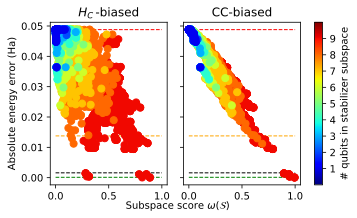

In [31]:
from matplotlib.pyplot import Normalize

fig,axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5,3),
                           gridspec_kw={'width_ratios': [10, 10, 1]})
        
#data = randomized[speciesname]
n_qubits = ham_tap.n_qubits
n_qubits_full = molecule.n_qubits
hf_energy = molecule.hf_energy
mp2_energy = molecule.mp2_energy
ccsd_energy = molecule.ccsd_energy
fci_energy = molecule.fci_energy
ham_ucc_nrg = results_out
increments=[]

for n_sim_qubits,results in ham_ucc_nrg.items():
    ratio = int(n_sim_qubits)/n_qubits
    increments.append(ratio)
    c = plt.cm.jet(ratio)
    X_ham, X_ucc, X_nrg = zip(*results)
    X_ham = np.array(X_ham)
    X_ucc = np.array(X_ucc)
    Y_nrg = np.array(X_nrg) - fci_energy

    axes[0].scatter(X_ham,Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)
    axes[1].scatter(X_ucc,Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)

def plot_lines(axis):
    axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
    axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
    axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
    axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')
plot_lines(axes[0])
plot_lines(axes[1])

keys = list(ham_ucc_nrg.keys())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                     ax=axes[2], label='# qubits in stabilizer subspace', ticks=increments, fraction=1.2)
cbar.ax.set_yticklabels(keys)

axes[0].set_title('$H_{C}\,$-biased')
axes[1].set_title('CC-biased')
axes[0].set_ylabel('Absolute energy error (Ha)')
axes[1].set_xlabel('Subspace score $\omega(\mathcal{S})$')
axes[1].xaxis.set_label_coords(-0.05,-0.1)
axes[2].set_visible(False)    

filename = f'plots/{speciesname}_score_vs_energy.png'

In [26]:
results_out

{}